In [11]:
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from analysis_utils import *
from nlp_synt_data import *
from data.texts import *
from data.training import *

In [12]:
df = pd.read_json('data/dbdump_testdb.jobs_v5.json')
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
# df = df[df['company'].str.contains('ecco')]
# df['description'].unique().tolist()
df[df['description'].str.contains('contattato')]['description'].unique().tolist()

/var/folders/l9/p2tp5gr9171dtk7txwfptt100000gn/T/ipykernel_19093/683081029.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


["siamo alla ricerca di un/a operatore/operatrice addetto/a alla cassa e allo sportello bancario per una prestigiosa realtà del settore bancario con sede in provincia di bergamo. requisiti richiesti: - diploma di scuola superiore e/o laurea in discipline economiche o finanziarie - esperienza pregressa nel ruolo di cassiere/cassiera o addetto/addetta allo sportello bancario - capacità di gestire le operazioni di cassa, inclusi pagamenti, prelievi e depositi - conoscenza dei principali strumenti informatici e software bancari - capacità di lavorare in autonomia e di gestire situazioni di stress - ottime capacità comunicative e relazionali - precisione e attenzione ai dettagli responsabilità: - gestione delle operazioni di cassa, inclusi pagamenti, prelievi e depositi - accoglienza e assistenza ai clienti presso lo sportello bancario - fornire informazioni sui prodotti e servizi bancari - promuovere e vendere prodotti e servizi finanziari - mantenere la cassa in ordine e bilanciata ... co

In [13]:
df = pd.read_csv('data/job_description_seed_dataset_improved_context.csv')
df['len'] = df.apply(lambda x: len(x['text']), axis=1)
df.sort_values('len', ascending=False, inplace=True)
df[df['inclusive phrasing'] == 'NO'].head(100)['text'].iloc[14]

"La risorsa inserita si occuperà delle seguenti attività: Gestione e smistamento corrispondenza generale: mail, telefono, chat; Gestione sale riunioni: prenotazioni e cura dell’ordine delle sale; Gestione attività di segreteria generale: a supporto di colleghi e responsabili; Monitoraggio sistemi di sicurezza; Gestione trasferte e viaggi; Coordinamento eventi interni: riunioni interne, meeting, formazione, piccoli eventi interni; Attività varie a supporto dell'area Marketing."

In [14]:
df = pd.read_csv('data/raw_data_finetune.csv')
df['text_JOB_value'] = df.apply(lambda x: x['text_JOB_value'] if isinstance(x['text_JOB_value'],str) else "", axis=1)
df['text_ADJ_value'] = df.apply(lambda x: x['text_ADJ_value'] if isinstance(x['text_ADJ_value'],str) else "", axis=1)
df['text_VERB_value'] = df.apply(lambda x: x['text_VERB_value'] if isinstance(x['text_VERB_value'],str) else "", axis=1)
df_jobs = df[df['text_JOB_value'] != ""]
df_adj = df[df['text_ADJ_value'] != ""]
df_verb = df[df['text_VERB_value'] != ""]
df_other = df[(df['text_JOB_value'] == "") & (df['text_ADJ_value'] == "") & (df['text_VERB_value'] == "")]
tot = len(df)
tot, len(df_jobs)/tot, len(df_adj)/tot, len(df_verb)/tot, len(df_other)/tot

(7017,
 0.42639304546102325,
 0.5472424112868748,
 0.008550662676357419,
 0.01781388057574462)

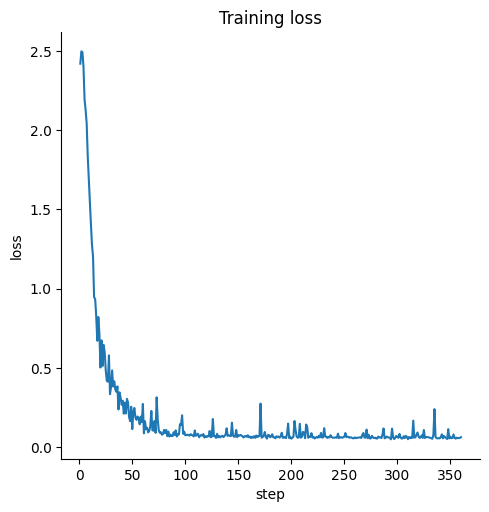

In [15]:
df_loss = pd.DataFrame({
    'step': [int(ln.split('	')[0]) for ln in TRAINING_LOSS.split('\n')],
    'loss': [float(ln.split('	')[1]) for ln in TRAINING_LOSS.split('\n')],
})
sns.relplot(data=df_loss, x='step', y='loss', kind='line')
plt.title('Training loss')
plt.show()

phi3-finetuned
   count    %     df prompt_id           true
0  370.0  1.0    raw     zsl#0      INCLUSIVO
0  370.0  1.0  fixed     zsl#0      INCLUSIVO
0  130.0  1.0    raw     zsl#0  NON INCLUSIVO
0  130.0  1.0  fixed     zsl#0  NON INCLUSIVO


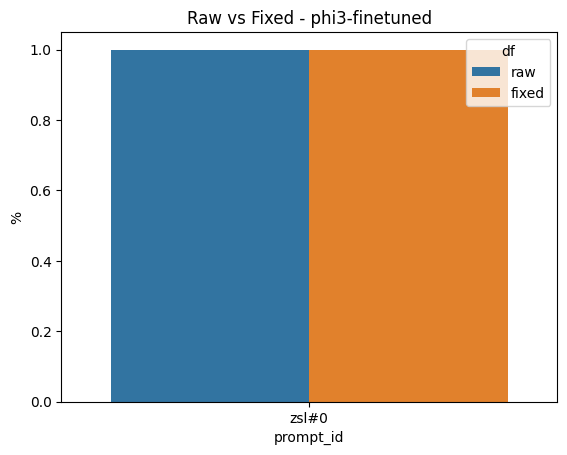

zsl#0


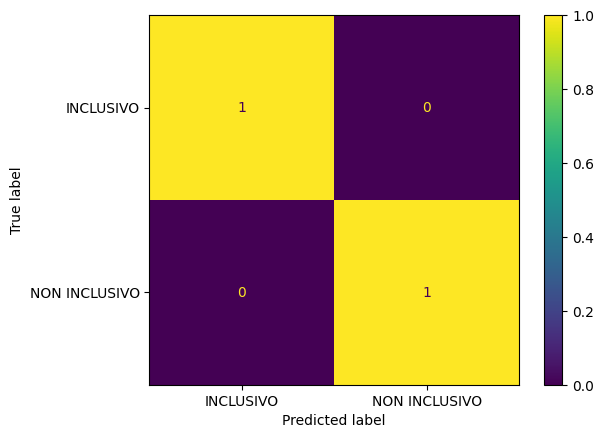

/var/folders/l9/p2tp5gr9171dtk7txwfptt100000gn/T/ipykernel_19093/2422312718.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])
/var/folders/l9/p2tp5gr9171dtk7txwfptt100000gn/T/ipykernel_19093/2422312718.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])


ZeroDivisionError: division by zero

In [16]:
res_models_df = None

show_plots = True

for model in ['phi3-finetuned']:
    print(model)
    if model == 'phi3-finetuned':
        df = pd.read_csv(f'results/{model}-eval-v0.csv')
    # df = df[df['prompt_id'].str.contains('cot')]

    df_fix = fix_df(df, model, show_plot=show_plots)
    # df_fix

    # print(df_fix['true'].value_counts())
    # print(df_fix['response'].value_counts())

    for p in df_fix['prompt_id'].unique():
        print(p)

        _df = df_fix[df_fix['prompt_id'] == p]
        df_jobs = _df[_df['text_labels'] == 'TODO']
        df_notjobs = _df[_df['text_labels'] != 'TODO']
        
        # sns.countplot(data=df_jobs, x='true')
        # plt.show()

        cm = skm.confusion_matrix(_df['true'], _df['response'], labels=LABELS, normalize='true')
        disp = skm.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
        disp.plot()
        plt.show()

        all = metrics(_df)
        all['name'] = 'all'
        res_df = pd.DataFrame(all, index=[0])
        all['name'] = model + " - " + p
        if res_models_df is None:
            res_models_df = pd.DataFrame(all, index=[0])
        else:
            res_models_df = pd.concat([res_models_df, pd.DataFrame(all, index=[0])])


        _metrics = metrics(df_jobs)
        _metrics['name'] = 'jobs'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_notjobs)
        _metrics['name'] = 'notjobs'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        # _metrics = metrics(isin(df_jobs, NEUTRALS))
        # _metrics['name'] = 'neutrals'
        # res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        # symbols = ['Ã',' e ',' o ','\*','/']
        # for s in symbols:
        #     _metrics = metrics(contains(df_jobs, [s]))
        #     _metrics['name'] = s
        #     res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_notjobs[df_notjobs['true'] == 'INCLUSIVO'])
        _metrics['name'] = 'notjob_inclusive'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_notjobs[df_notjobs['true'] == 'NON INCLUSIVO'])
        _metrics['name'] = 'notjob_not_inclusive'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_jobs[df_jobs['true'] == 'INCLUSIVO'])
        _metrics['name'] = 'job_inclusive'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_jobs[df_jobs['true'] == 'NON INCLUSIVO'])
        _metrics['name'] = 'job_not_inclusive'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        if show_plots:
            print(res_df)
            plot_metrics(res_df, f" - {model} - {p}")

plot_metrics(res_models_df, "- All models")